In [1]:
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import GridSearchCV
import numpy as np

In [2]:
data = pd.read_csv("Hitters.csv")
data.drop("Unnamed: 0", axis=1, inplace=True)

In [3]:
cols = (data.dtypes == 'int64') | (data.dtypes == 'float64')
data = data.loc[:, cols]

In [4]:
def missing_value_calculator(dataset):
    # which columns have missing values
    indexer = dataset.isnull().sum() > 0
    
    # Raw counts of missing values
    raw = dataset.isnull().sum()[indexer].sort_values(ascending=False)
    
    # percentage of missing values
    percentage = ((dataset.isnull().sum()/dataset.shape[0])
                    *100)[indexer].sort_values(ascending=False)

    # combine the two dataframes into 1 output
    output = pd.concat([raw, percentage], axis=1, ignore_index=False, 
                       keys=['# Missing', 'Percent Missing'])
    return output

In [5]:
missing_value_calculator(data)

,# Missing,Percent Missing
Salary,59,18.322981


In [6]:
data.dropna(axis=0, inplace=True)

# 1.1 
Use LASSO regression to predict Salary from the other numeric predictors.  Create a visualization of the coefficient trajectories.  Comment on which are the final three predictors that remain in the model.  Use cross-validation to find the optimal value of the regularization penalty.  How many predictors are left in that model?

In [15]:
nums = np.logspace(-1, 1.5, 1000)
params = {'alpha':nums}
x = data.drop('Salary', axis=1)
y = data.loc[:, 'Salary']

In [9]:
cv = GridSearchCV(Lasso(max_iter=5000, tol=.8, normalize=True), params, cv=10, scoring='neg_mean_squared_error')
cv.fit(x, y)
# Using cross validation to find optimal value for regularization penalty.
cv.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 10.0}

In [16]:
# Create visualization of the coefficient trajectories.
coefs = []
for a in nums:
    lasso_model = Lasso(max_iter=5000, tol=.8, alpha=a, normalize=True)
    lasso_model.fit(x, y)
    coefs.append(lasso_model.coef_)

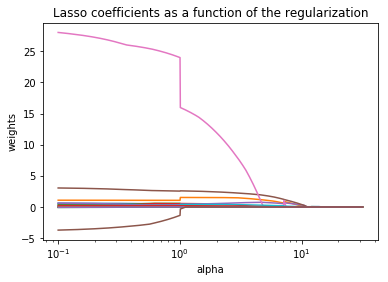

In [17]:
ax = plt.gca()
ax.plot(nums, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Lasso coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [24]:
inv_coefs = coefs[::-1]

In [29]:
inv_coefs[150] # checked random values of alpha to find when 3 predictor coefficients are left.

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.01851509, 0.        ,
       0.05818699, 0.02998236, 0.        , 0.        , 0.        ,
       0.        ])

In [30]:
x.columns # Matching the position of the names to the positions of the coefficents.  

Index(['AtBat', 'Hits', 'HmRun', 'Runs', 'RBI', 'Walks', 'Years', 'CAtBat',
       'CHits', 'CHmRun', 'CRuns', 'CRBI', 'CWalks', 'PutOuts', 'Assists',
       'Errors'],
      dtype='object')

In [33]:
lasso_model = Lasso(max_iter=5000, tol=.8, alpha=10, normalize=True)
lasso_model.fit(x, y)
lasso_model.coef_

array([0.        , 0.12832597, 0.        , 0.        , 0.32723572,
       0.39106155, 0.        , 0.02161467, 0.03075086, 0.04335776,
       0.02906864, 0.02413362, 0.        , 0.        , 0.        ,
       0.        ])

CHits, CRuns, and CRBI are the three variables that are last to approach 0.  Using cross-validation and normalization, 10 is found to be the optimal alpha for the model.  There are 8 predictors left.  

# 1.2
Repeat with Ridge Regression.  Visualize coefficient trajectories.  Use cross-validation to find the optimal value of the regularization penalty.  

In [44]:
nums = np.logspace(1, 4, 1000)

In [34]:
cv = GridSearchCV(Ridge(max_iter=5000, tol=.8, normalize=True), params, cv=10, scoring='neg_mean_squared_error')
cv.fit(x, y)
# Using cross validation to find optimal value for regularization penalty.
cv.best_params_

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\model_selection\_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


{'alpha': 0.1}

In [45]:
# Create visualization of the coefficient trajectories.
coefs = []
for a in nums:
    lasso_model = Ridge(max_iter=5000, tol=.8, alpha=a, normalize=True)
    lasso_model.fit(x, y)
    coefs.append(lasso_model.coef_)

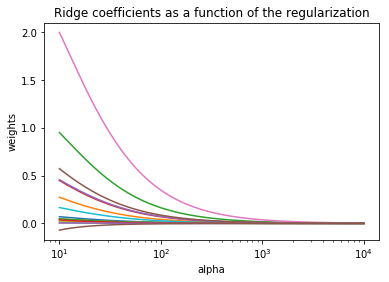

In [46]:
ax = plt.gca()
ax.plot(nums, coefs)
ax.set_xscale('log')
plt.xlabel('alpha')
plt.ylabel('weights')
plt.title('Ridge coefficients as a function of the regularization')
plt.axis('tight')
plt.show()

In [48]:
ridge_model = Ridge(max_iter=5000, tol=.8, alpha=.1, normalize=True)
ridge_model.fit(x, y)
ridge_model.coef_

array([-4.63652353e-01,  2.10643287e+00, -2.28423847e+00,  1.35976067e+00,
        1.15555591e+00,  2.81974860e+00, -6.56549694e+00,  3.56703039e-03,
        1.07356602e-01,  6.14058483e-01,  2.40508488e-01,  2.16115370e-01,
       -1.43558269e-01,  2.59934339e-01,  1.33756227e-01, -3.16063393e+00])

The optimal value of alpha is .1.

# 2
Explain in your own words the bias-variance tradeoff.  What role does regularization play in this tradeoff?  Make references to your findings in number 1 to describe models of high/low bias and variance. 

An underfit model will have high bias and an overfit model will have high variance.  High bias is another way of saying that the predictions will deviate far from the true values.  High variance means that slight changes to the training set will create vastly different coefficients in a model.  Regularization includes a penalty that stops a model from overfitting.  In exercise 1, as the regularization parameter is increased, the coefficients tend towards 0.  This is equivalent to reducing the variance of the model, but will slightly increase the bias.  A balance between the two will result in an optimal model.